# <center> IOT INF730 - TP Geoloc </center>

Groupe :
- Nicolas Louis
- Thomas Koch
- Xavier Bracquart
- Philippe Bénézeth

<strong> Objectif : Prédire la position du message (latitude/longitude) </strong>

## Initialisation

In [138]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 300)

import matplotlib.pyplot as plt
%matplotlib inline
import math

# from geopy.distance import vincenty - deprecated remplacé par geodesic
from geopy.distance import geodesic
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_predict
#from sklearn.model_selection import GridSearchCV
#from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
#from sklearn.metrics import accuracy_score

#import warnings
#warnings.filterwarnings("ignore")

## Chargement des data

In [139]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')

# nbr d'observations
print("nbr d'observations du train", df_mess_train.shape[0])
print("nbr d'observations du test", df_mess_test.shape[0])

# on réunit les data de train et de test
df_mess = pd.concat([df_mess_train, df_mess_test])

# On rassemble la table de features avec la liste de label
df_mess_train[['pos_lat', 'pos_lng']] = pos_train

nbr d'observations du train 39250
nbr d'observations du test 29286


# Exploration des data

#### Data du train

In [140]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,pos_lat,pos_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940


#### Data du test

In [141]:
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


#### Nombre de valeurs uniques par colonne ( pour les data du train, du test et de la réunion)

In [142]:
print('---Data de train---')
print("Nombre de messages uniques : %d" %df_mess_train.messid.nunique())
print("Nombre de stations uniques : %d" %df_mess_train.bsid.nunique())
print("Nombre de devices uniques : %d" %df_mess_train.did.nunique())
print("Nombre de valeurs uniques de time_ux : %d" %df_mess_train.time_ux.nunique())
print("Nombre de valeurs uniques de rssi : %d" %df_mess_train.rssi.nunique())
print("Nombre de valeurs uniques de nseq: %d" %df_mess_train.nseq.nunique())
print("Nombre de valeurs uniques de bs_lat : %d" %df_mess_train.bs_lat.nunique())
print("Nombre de valeurs uniques de bs_lng: %d" %df_mess_train.bs_lng.nunique())
print("Nombre de valeurs uniques de poslat: %d" %pos_train.lat.nunique())
print("Nombre de valeurs uniques de poslng: %d" %pos_train.lng.nunique())

---Data de train---
Nombre de messages uniques : 6068
Nombre de stations uniques : 251
Nombre de devices uniques : 113
Nombre de valeurs uniques de time_ux : 6067
Nombre de valeurs uniques de rssi : 276
Nombre de valeurs uniques de nseq: 5
Nombre de valeurs uniques de bs_lat : 221
Nombre de valeurs uniques de bs_lng: 221
Nombre de valeurs uniques de poslat: 6004
Nombre de valeurs uniques de poslng: 6004


Remarques :  
Il y a 2 messages qui ont le même time_ux...  
Il y a plus de poslat poslng que de messages... il faudra faire une moyenne  
Il y a plus de base stations que de bs_lat bs_lng ...

In [143]:
print('---Data de test---')
print("Nombre de messages uniques : %d" %df_mess_test.messid.nunique())
print("Nombre de stations uniques : %d" %df_mess_test.bsid.nunique())
print("Nombre de devices uniques : %d" %df_mess_test.did.nunique())
print("Nombre de valeurs uniques de time_ux : %d" %df_mess_test.time_ux.nunique())
print("Nombre de valeurs uniques de rssi : %d" %df_mess_test.rssi.nunique())
print("Nombre de valeurs uniques de nseq: %d" %df_mess_test.nseq.nunique())
print("Nombre de valeurs uniques de bs_lat : %d" %df_mess_test.bs_lat.nunique())
print("Nombre de valeurs uniques de bs_lng: %d" %df_mess_test.bs_lng.nunique())

---Data de test---
Nombre de messages uniques : 5294
Nombre de stations uniques : 168
Nombre de devices uniques : 56
Nombre de valeurs uniques de time_ux : 5294
Nombre de valeurs uniques de rssi : 255
Nombre de valeurs uniques de nseq: 5
Nombre de valeurs uniques de bs_lat : 142
Nombre de valeurs uniques de bs_lng: 142


Remarque : ici aussi il y a plus de base stations que de bs_lat bsl_lng ...

In [144]:
print('---Data de train + test---')
print("Nombre de messages uniques : %d" %df_mess.messid.nunique())
print("Nombre de stations uniques : %d" %df_mess.bsid.nunique())
print("Nombre de devices uniques : %d" %df_mess.did.nunique())
print("Nombre de valeurs uniques de time_ux : %d" %df_mess.time_ux.nunique())
print("Nombre de valeurs uniques de rssi : %d" %df_mess.rssi.nunique())
print("Nombre de valeurs uniques de nseq: %d" %df_mess.nseq.nunique())
print("Nombre de valeurs uniques de bs_lat : %d" %df_mess.bs_lat.nunique())
print("Nombre de valeurs uniques de bs_lng: %d" %df_mess.bs_lng.nunique())

---Data de train + test---
Nombre de messages uniques : 11362
Nombre de stations uniques : 259
Nombre de devices uniques : 169
Nombre de valeurs uniques de time_ux : 11360
Nombre de valeurs uniques de rssi : 286
Nombre de valeurs uniques de nseq: 5
Nombre de valeurs uniques de bs_lat : 227
Nombre de valeurs uniques de bs_lng: 227


Remarques :  
Le nombre de messages et de devices est exactement la somme train + test : on peut deviner qu'il n'y a pas d'intersection
Mêmes remarques que précédemment sur les base stations et les bs_lat bs_lng ...

### Comparons les distributions des valeurs de certaines variables entre train et test

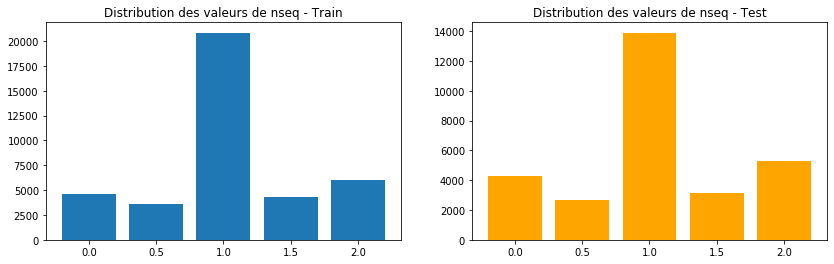

In [145]:
plt.figure(figsize=(14,4))
plt.subplot(121)
l = sorted(list(df_mess_train.nseq.unique()))
plt.bar(l, list(len(df_mess_train.nseq[df_mess_train.nseq==x]) for x in l), width=0.4)
plt.title("Distribution des valeurs de nseq - Train")
plt.subplot(122)
l = sorted(list(df_mess_test.nseq.unique()))
plt.bar(l, list(len(df_mess_test.nseq[df_mess_test.nseq==x]) for x in l), width=0.4, color="orange")
plt.title("Distribution des valeurs de nseq - Test")
plt.show()

nseq prend 5 valeurs avec une distribution similaire pour les dataset train et test, un peu plus de valeurs extrêmes pour le test.

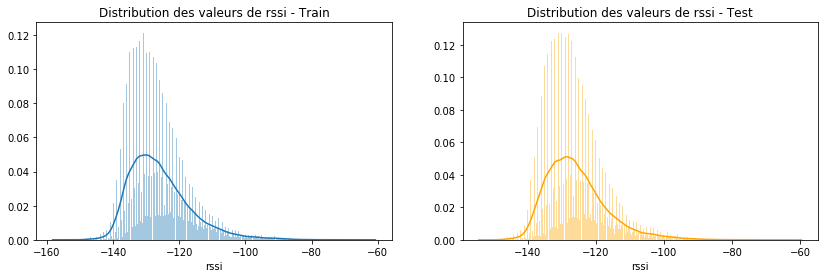

In [146]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(df_mess_train.rssi, bins=300)
plt.title("Distribution des valeurs de rssi - Train")
plt.subplot(122)
sns.distplot(df_mess_test.rssi, bins=300, color='orange')
plt.title("Distribution des valeurs de rssi - Test")
plt.show()

Distribution identique entre train et test pour les valeurs de rssi.

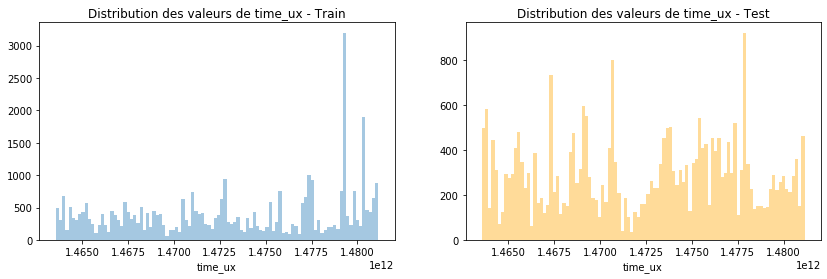

In [147]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(df_mess_train.time_ux, bins=100, kde=False)
plt.title("Distribution des valeurs de time_ux - Train")
plt.subplot(122)
sns.distplot(df_mess_test.time_ux, bins=100, kde=False, color='orange')
plt.title("Distribution des valeurs de time_ux - Test")
plt.show()

Les valeurs sont comprises à peu près entre les mêmes bornes.

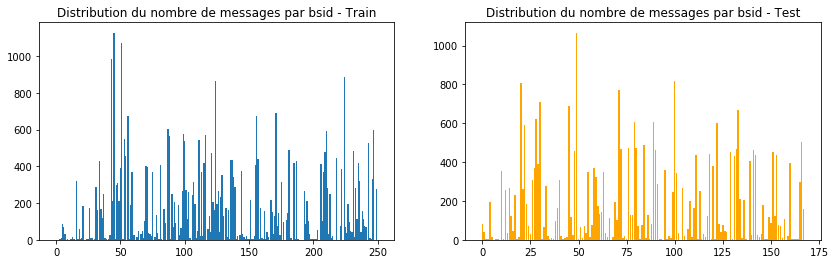

In [148]:
plt.figure(figsize=(14,4))
plt.subplot(121)
abcisse = list((x for x in range(0,df_mess_train.bsid.nunique())))
plt.bar(abcisse, list(df_mess_train.groupby(['bsid']).messid.nunique()), width=1)
plt.title("Distribution du nombre de messages par bsid - Train")
plt.subplot(122)
abcisse = list((x for x in range(0,df_mess_test.bsid.nunique())))
plt.bar(abcisse, list(df_mess_test.groupby(['bsid']).messid.nunique()), width=0.8, color='orange')
plt.title("Distribution du nombre de messages par bsid - Test")
plt.show()

La distribution est similaire entre les deux dataset. On remarque que certaines base station reçoivent beaucoup plus de messages que les autres.

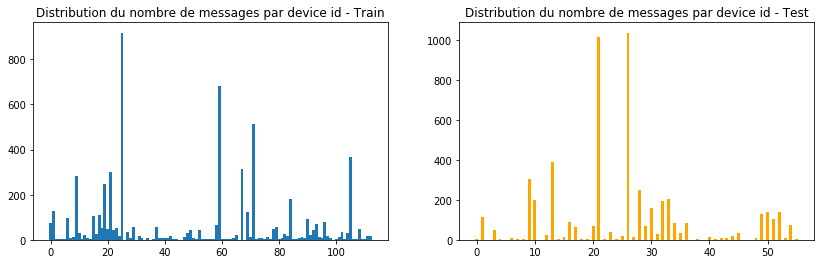

In [149]:
plt.figure(figsize=(14,4))
plt.subplot(121)
abcisse = list((x for x in range(0,df_mess_train.did.nunique())))
plt.bar(abcisse, list(df_mess_train.groupby(['did']).messid.nunique()), width=1)
plt.title("Distribution du nombre de messages par device id - Train")
plt.subplot(122)
abcisse = list((x for x in range(0,df_mess_test.did.nunique())))
plt.bar(abcisse, list(df_mess_test.groupby(['did']).messid.nunique()), width=0.5, color='orange')
plt.title("Distribution du nombre de messages par device id - Test")
plt.show()

On constate une grande différence dans le nombre de messages reçus par les différents devices.

### Corrélation entre les variables

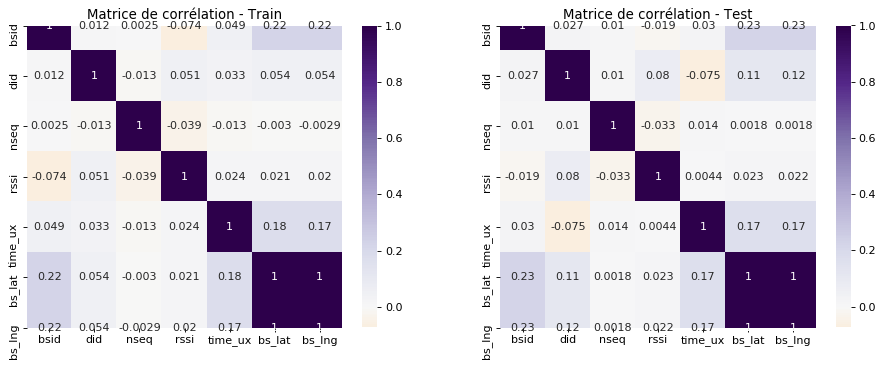

In [150]:
plt.figure(figsize=(14,5), dpi= 80)
plt.subplot(121)
sns.heatmap(df_mess_train.iloc[:,:-2].corr(), xticklabels=df_mess_train.iloc[:,:-2].corr().columns,
            yticklabels=df_mess_train.iloc[:,:-2].corr().columns, cmap='PuOr', center=0, annot=True)
plt.title('Matrice de corrélation - Train', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.subplot(122)
sns.heatmap(df_mess_test.corr(), xticklabels=df_mess_test.corr().columns,
            yticklabels=df_mess_test.corr().columns, cmap='PuOr', center=0, annot=True)
plt.title('Matrice de corrélation - Test', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

On n'observe pas de corrélations importantes entre les variables à part entre la latitute et la longitude des stations.

# On est ici

### Détection des outliers

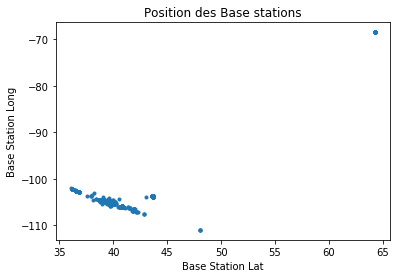

In [151]:
# Plot bs latitude vs bs longitude
plt.figure(figsize=(6,4))
plt.plot(df_mess['bs_lat'], df_mess['bs_lng'], '.')
plt.title('Position des Base stations')
plt.xlabel('Base Station Lat')
plt.ylabel('Base Station Long')
plt.show()

On remarque qu'il y a une partie des base stations qui sont éloignées des autres avec une longitude et latitude proche de -70 et 65. 

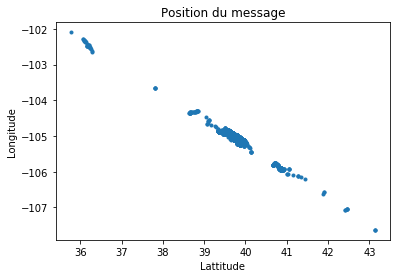

In [152]:
# Plot message latitude vs message longitude
plt.figure(figsize=(6,4))
plt.plot(df_mess_train.pos_lat, df_mess_train.pos_lng, ".")
plt.title("Position du message")
plt.xlabel("Lattitude")
plt.ylabel("Longitude")
plt.show()

En observant les positions réelles des messages envoyés par les devices, on remarque qu'il y a aucun message envoyé à des longitudes et latitudes proches de -70 et 65. On conclut qu'il s'agit d'une erreur dans la position de ces base stations.

On essaye de trouver des stations de base qui ont des positions extrêmes par rapport au reste et voir si il est pertinent ou pas de les garder.

In [153]:
# Nbr d'observations liées aux Base station ayant une latitude > 60 ou une longitude >-80
df_mess_train[(df_mess_train['bs_lat']>60) | (df_mess_train['bs_lng']>(-80))].bsid.count()

4389

Même si le nombre de message associé à ces bsid est assez significatif (environ 4389 / 39 250), on décide de retirer les obsevations liées car cela va induire en erreur notre algorithme.

In [154]:
df_mess_train = df_mess_train[(df_mess_train['bs_lat']<=60) & (df_mess_train['bs_lng']<=(-80))]

### Détection des classes peu représentées

On choisit de détecter d'abord les base stations qui détectent peu de messages pour potentiellement les enlever du train set et ainsi avoir moins de catégories en entrée de l'algorithme de prédiction par la suite.

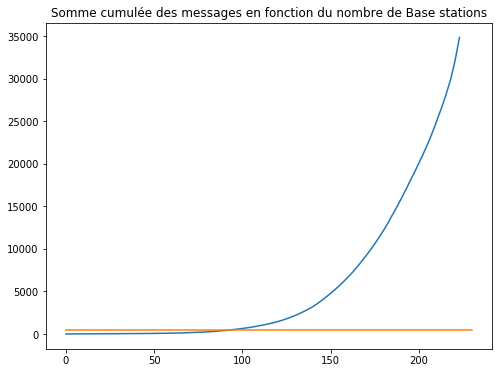

In [155]:
# On repère les base stations qui ne reçoivent pas beaucoup de messages
count_basestation = df_mess_train.groupby('bsid').count()
count_basestation = count_basestation['messid']
obs_limit = 500
plt.figure(figsize=(8,6))
count_basestation_cum = count_basestation.sort_values(ascending=True).cumsum()
plt.plot(count_basestation_cum.values)
plt.plot([0,230], [obs_limit,obs_limit])
plt.title("Somme cumulée des messages en fonction du nombre de Base stations", size=12)
plt.show()

In [156]:
print("Nombre de Base stations en dessous de la droite orange: %d" %len(
                 count_basestation_cum[count_basestation_cum<obs_limit]))

Nombre de Base stations en dessous de la droite orange: 95


On décide de retirer les observations de ces 95 Base stations.

In [157]:
# Les bsid qui ne reçoivent pas beaucoup de messages sont retirés des données train
bsid_to_remove = count_basestation_cum[count_basestation_cum<obs_limit].index.values
df_mess_train = df_mess_train[~df_mess_train.bsid.isin(bsid_to_remove)]

# Remise des index par défaut pour le train dataframe pour la jointure des dataframes par la suite
df_mess_train = df_mess_train.reset_index().drop(columns=['index'])
n_train = df_mess_train.shape[0]

## Features Engineering

In [158]:
# On concatène le train et le test set
df_concact = pd.concat([df_mess_train.iloc[:,:-2], df_mess_test] )

### Catégorisation Base station

In [159]:
# On détermine tous les base stations prises en compte dans le train set
# (après suppression des base stations peu représentées) et le test set

listOfBs = np.unique(df_concact.bsid)
listNameBs = ["bs"+str(code) for code in listOfBs]

In [160]:
print("Nombre de stations de Base stations prises en compte au final: ", len(listOfBs))

Nombre de stations de Base stations prises en compte au final:  178


In [161]:
# OneHotEncoder pour bsid
ohe = OneHotEncoder()
X_bsid = ohe.fit_transform(df_concact[['bsid']]).toarray()
df_bsid_train = pd.DataFrame(X_bsid[:n_train,:], columns = listNameBs)
df_bsid_test = pd.DataFrame(X_bsid[n_train:,:], columns = listNameBs)

In [162]:
# On rajoute ces colonnes catégorielles à nos dataset Train et Test
df_mess_train[listNameBs] = df_bsid_train
df_mess_test[listNameBs] = df_bsid_test

### Catégorisation Device ID

In [163]:
# On détermine tous les device id pris en compte dans le train set et le test set
list_did = np.unique(df_concact.did)
listNamedid = ["did"+str(int(i)) for i in list_did]

In [164]:
print("Nombre de devices uniques pris en compte au final: ", len(list_did))

Nombre de devices uniques pris en compte au final:  168


Le nombre de devices uniques est élevé ce qui va créer beaucoup de features et risque d'alourdir notre modèle. On verra lors de la sélection des features celles qui pourraient être supprimées.

In [165]:
# OneHotEncoder pour did
ohe = OneHotEncoder()
X_did = ohe.fit_transform(df_concact[['did']]).toarray()
df_did_train = pd.DataFrame(X_did[:n_train,:], columns = listNamedid)
df_did_test = pd.DataFrame(X_did[n_train:,:], columns = listNamedid)

In [166]:
# On rajoute ces colonnes catégorielles à nos dataset Train et Test
df_mess_train[listNamedid] = df_did_train
df_mess_test[listNamedid] = df_did_test

### Groupby par MessID

In [167]:
# On groupe par messid
df_grouped_train = df_mess_train.groupby(['messid'])
df_grouped_test = df_mess_test.groupby(['messid'])

### Mise à 1 de tous les bsid du MessID

In [168]:
# On met un 1 dans la colonne de la bs si la bs a reçu ce messid 
# remarque on met max mais c'est soit 1 soit 0
df_bsid_grouped_train = df_grouped_train.sum()[listNameBs]
df_bsid_grouped_test = df_grouped_test.sum()[listNameBs]

 #### Nombre de bsid par MessID

In [169]:
# On crée la variable du nombre total de bsid par message
count_bsid_grouped_train = df_bsid_grouped_train.sum(axis=1).values
count_bsid_grouped_test = df_bsid_grouped_test.sum(axis=1).values

In [170]:
print('train : ','min = ', count_bsid_grouped_train.min(), 'max = ', count_bsid_grouped_train.max())
print('test : ','min = ', count_bsid_grouped_test.min(), 'max = ', count_bsid_grouped_test.max())

train :  min =  1.0 max =  67.0
test :  min =  1.0 max =  64.0


#### Mise à 1 du did du MessID

On vérifie ici qu'il n'y a bien qu'un did par message

In [171]:
# aucune impression, ceci confirme que pour un message, c'est toujours le même did
for key, elmt in df_grouped_train:
        #dfg = df_grouped_train.get_group(key)
        if (elmt['did'].nunique() != 1):
            print(elmt['did'].nunique())

In [172]:
# On met un 1 dans la colonne du device id si le did a émis ce messid 
# remarque on met max mais c'est soit 1 soit 0
df_did_grouped_train = df_grouped_train.max()[listNamedid]
df_did_grouped_test = df_grouped_test.max()[listNamedid]

 #### Le DeviceID du MessID

In [173]:
# Moyenne des Device ID par messid, en fait ce n'est pas la moyenne, c'est l'unique did du message !
did_grouped_train = df_grouped_train.mean()['did'].values
did_grouped_test = df_grouped_test.mean()['did'].values

 #### Moyenne du RSSI par MessID

In [174]:
# Moyenne du RSSI par messid
rssi_grouped_train = df_grouped_train.mean()['rssi'].values
rssi_grouped_test = df_grouped_test.mean()['rssi'].values

#### Moyenne des lat/long des bs qui ont reçu le message  

In [175]:
# Addition de features latitude et longitude moyenne
lat_grouped_train = df_grouped_train.mean()['bs_lat'].values
lat_grouped_test = df_grouped_test.mean()['bs_lat'].values

lng_grouped_train = df_grouped_train.mean()['bs_lng'].values
lng_grouped_test = df_grouped_test.mean()['bs_lng'].values

#### Moyenne des lat/long pondérée par le RSSI 

In [176]:
# Addition de features latitude et longitude moyenne pondérées par rssi
lat_rssi_grouped_train = np.array([np.average(elmt['bs_lat'], weights=elmt['rssi']) for key, elmt in df_grouped_train])
lat_rssi_grouped_test = np.array([np.average(elmt['bs_lat'], weights=elmt['rssi']) for key, elmt in df_grouped_test])

lng_rssi_grouped_train = np.array([np.average(elmt['bs_lng'], weights=elmt['rssi']) for key, elmt in df_grouped_train])
lng_rssi_grouped_test = np.array([np.average(elmt['bs_lng'], weights=elmt['rssi']) for key, elmt in df_grouped_test])                                      

#### Moyenne des time_ux des bs qui ont reçu le message  

In [177]:
# Moyenne time_ux par messid
time_ux_grouped_train = df_grouped_train.mean()['time_ux'].values
time_ux_grouped_test = df_grouped_test.mean()['time_ux'].values

#### Moyenne des lat/long pondérée par le time_ux 

In [178]:
# lat/long pondérées par time_ux
time_ux_lat_grouped_train = np.array([np.average(elmt['bs_lat'], weights=elmt['time_ux']) for key, elmt in df_grouped_train])
time_ux_lat_grouped_test = np.array([np.average(elmt['bs_lat'], weights=elmt['time_ux']) for key, elmt in df_grouped_test])

time_ux_lng_grouped_train = np.array([np.average(elmt['bs_lng'], weights=elmt['time_ux']) for key, elmt in df_grouped_train])
time_ux_lng_grouped_test = np.array([np.average(elmt['bs_lng'], weights=elmt['time_ux']) for key, elmt in df_grouped_test])

#### Moyenne des lat/long pondérée par le nseq 

In [179]:
# lat/long pondérées par nseq+1 (pour éviter les nseq à 0 !)
nseq_lat_grouped_train = np.array([np.average(elmt['bs_lat'], weights=elmt['nseq']+1) for key, elmt in df_grouped_train])
nseq_lat_grouped_test = np.array([np.average(elmt['bs_lat'], weights=elmt['nseq']+1) for key, elmt in df_grouped_test])

nseq_lng_grouped_train = np.array([np.average(elmt['bs_lng'], weights=elmt['nseq']+1) for key, elmt in df_grouped_train])
nseq_lng_grouped_test = np.array([np.average(elmt['bs_lng'], weights=elmt['nseq']+1) for key, elmt in df_grouped_test])

#### Moyenne des lat/long des labels (donc du device émetteur)

In [180]:
# Groupby label
pos_lat_grouped_train = df_grouped_train.mean()['pos_lat'].values
pos_lng_grouped_train = df_grouped_train.mean()['pos_lng'].values

# Features selection

In [181]:
# On met en place la combinaison des features qui a permis d'atteindre notre meilleur score
df_train = pd.DataFrame()
df_train[listNameBs] = df_bsid_grouped_train
df_train[listNamedid] = df_did_grouped_train
df_train['mean_rssi'] = rssi_grouped_train
df_train['mean_lat'] = lat_grouped_train
df_train['mean_lng'] = lng_grouped_train
df_train['mean_lat_rssi'] = lat_rssi_grouped_train
df_train['mean_lng_rssi'] = lng_rssi_grouped_train
df_train['mean_time_ux'] = time_ux_grouped_train
df_train['pos_lat'] = pos_lat_grouped_train
df_train['pos_lng'] = pos_lng_grouped_train

df_test = pd.DataFrame()
df_test[listNameBs] = df_bsid_grouped_test
df_test[listNamedid] = df_did_grouped_test
df_test['mean_rssi'] = rssi_grouped_test
df_test['mean_lat'] = lat_grouped_test
df_test['mean_lng'] = lng_grouped_test
df_test['mean_lat_rssi'] = lat_rssi_grouped_test
df_test['mean_lng_rssi'] = lng_rssi_grouped_test
df_test['mean_time_ux'] = time_ux_grouped_test

On veut avoir un aperçu de l'importance de nos features sur un modèle comme le RandomForest Regressor afin d'affiner la sélection de nos variables.

In [182]:
X_train = df_train.iloc[:,:-2]
y_lat_train = df_train['pos_lat']
y_lng_train = df_train['pos_lng']
X_test = df_test

In [183]:
clf_lat = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
clf_lat.fit(X_train, y_lat_train)
clf_lng = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
clf_lng.fit(X_train, y_lng_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [184]:
# Calcul des Features Importances 
dict_feature_importance_lat = {'feature': X_train.columns.values, 'importance': clf_lat.feature_importances_}
feature_importances_lat = pd.DataFrame(data=dict_feature_importance_lat).sort_values('importance', ascending=False)
dict_feature_importance_lng = {'feature': X_train.columns.values, 'importance': clf_lng.feature_importances_}
feature_importances_lng = pd.DataFrame(data=dict_feature_importance_lng).sort_values('importance', ascending=False)

In [185]:
feature_importances_lat

,feature,importance
348,mean_lng,0.502582
350,mean_lng_rssi,0.394662
347,mean_lat,0.082965
349,mean_lat_rssi,0.009571
346,mean_rssi,0.001709
...,...,...
207,did472518,0.000000
208,did472526,0.000000
209,did472533,0.000000
210,did472646,0.000000


In [186]:
feature_importances_lng

,feature,importance
348,mean_lng,0.599419
350,mean_lng_rssi,0.369159
347,mean_lat,0.014040
349,mean_lat_rssi,0.004688
346,mean_rssi,0.002016
...,...,...
202,did472427,0.000000
203,did472493,0.000000
204,did472504,0.000000
205,did472511,0.000000


In [187]:
seuil_importance = 0.000025

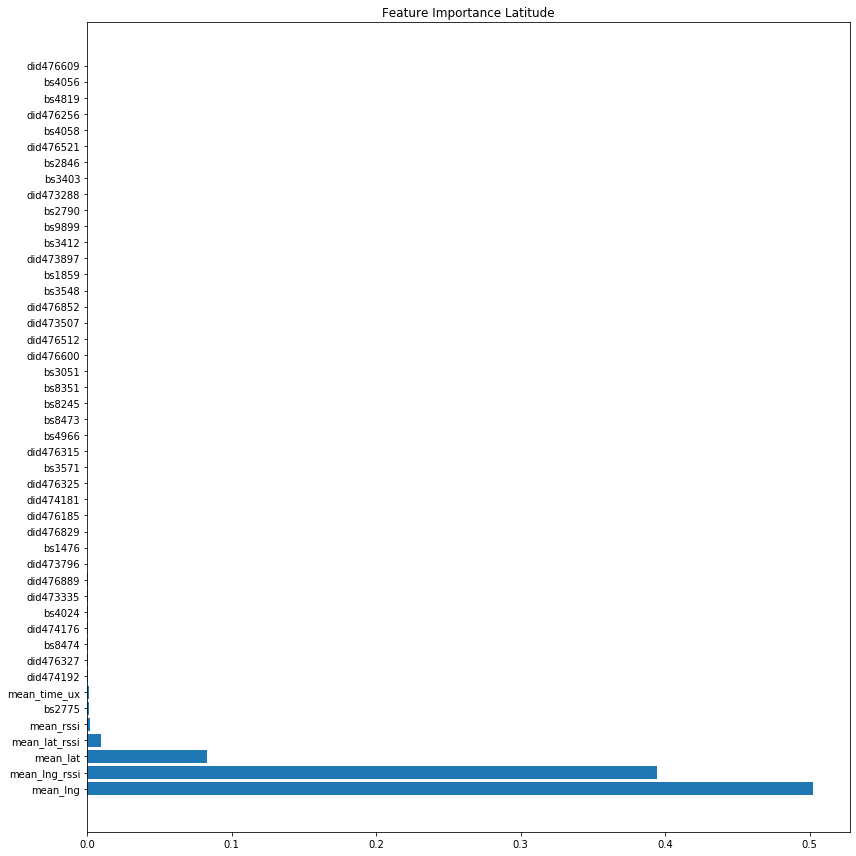

In [188]:
# plot des Features Importances pour la latitude
masque_lat = feature_importances_lat['importance'] > seuil_importance
plt.figure(figsize=(12,12))
plt.barh(feature_importances_lat['feature'][masque_lat], feature_importances_lat['importance'][masque_lat])       
plt.title('Feature Importance Latitude')
plt.tight_layout()
plt.show;

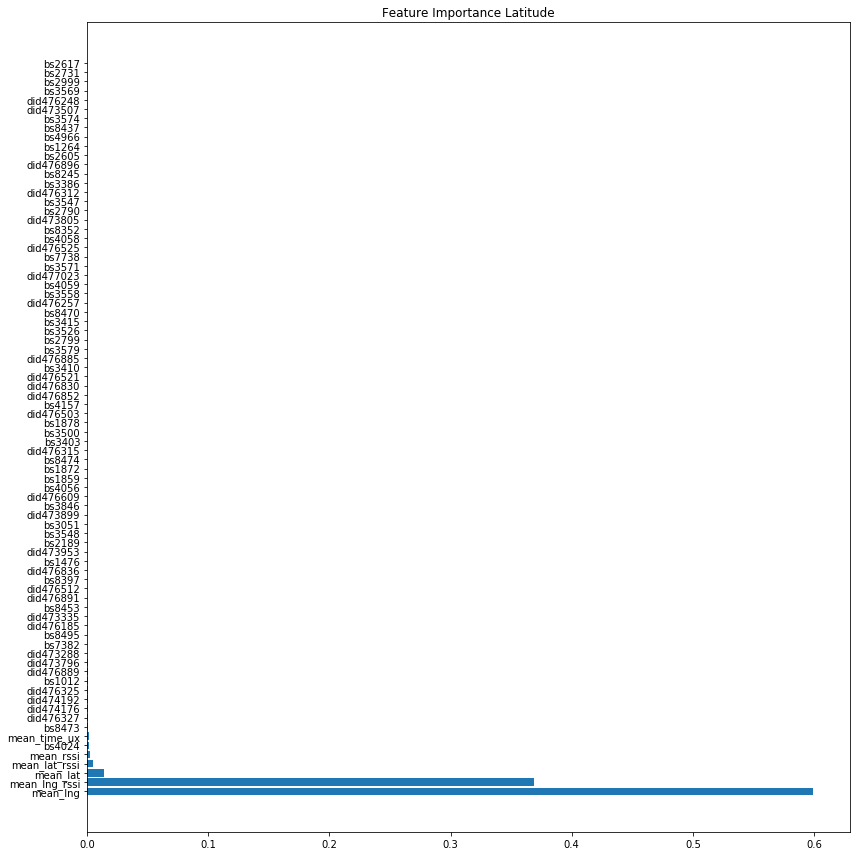

In [189]:
# plot des Features Importances pour la longitude
masque_lng = feature_importances_lng['importance'] > seuil_importance
plt.figure(figsize=(12,12))
plt.barh(feature_importances_lng['feature'][masque_lng], feature_importances_lng['importance'][masque_lng])      
plt.title('Feature Importance Latitude')
plt.tight_layout()
plt.show;

On remarque que la majorité de l'importance est captée entre quelques features. On va donc d'abord s'intéresser aux features dont l'importance est inférieure à 0.000025 et les retirer de nos train et test set.

In [190]:
# On enlève les features avec importance faible
# on passe par set pour utiliser l'intersection des ensembles
index_to_remove3 = list(set(feature_importances_lat['feature'][np.logical_not(masque_lat)]
         ).intersection(set(feature_importances_lng['feature'][np.logical_not(masque_lng)])))
print("%d features ont une importance inférieure à %.6f." %(len(index_to_remove3), seuil_importance))
X_train = X_train.drop(index_to_remove3, axis=1)
X_test = X_test.drop(index_to_remove3, axis=1)

261 features ont une importance inférieure à 0.000025.


# Fonctions fournies

### Calcul de distance à partir des lat et lng

In [191]:
# Fonction qui permet d'évaluer nos résultats
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        #vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
        vin_vec_dist = [geodesic(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [192]:
# Fonction pour évaluer l'erreur en distance
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    return err_vec

### Affichage Erreur Cumulative

In [193]:
 def grap_error(err_vec):
    # On affiche le graphe des erreurs de distance cumulées
    values, base = np.histogram(err_vec, bins=50000)
    cumulative = np.cumsum(values) 
    plt.figure()
    plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
    plt.grid()
    plt.xlabel('Distance Error (km)')
    plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]) 
    plt.title('Error Cumulative Probability')
    plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
    plt.show();

# Recherche d'un bon Modèle de prédiction

In [194]:
# Split train - test pour les Gridsearch 
Xtrain_cv, Xtest_cv, y_lat_train_cv, y_lat_test_cv, y_lng_train_cv, y_lng_test_cv = train_test_split(
                                    X_train, y_lat_train, y_lng_train, test_size=0.2, random_state=1966)

## Etude avec un RandomForest Regressor - hyper-paramètres testés : max_depth, max_features, n_estimators

In [196]:
# Gridsearch manuel (impossible d'utiliser les fonctions classiques car ici il y a 2 modèles à optimiser)
list_max_depth = [20, 25, 30, 35, 40, 45, 50, 55, 60]
list_max_features = [0.5, 0.6, 0.7, 0.8, 0.9, None]
list_n_estimators = [50, 100, 200]
  
err80 = 10000
list_result =[]
for max_depth in list_max_depth:
    for max_features in list_max_features:
        for n_estimators in list_n_estimators:
    
            clf_rf_lat = RandomForestRegressor(n_estimators = n_estimators, max_depth=max_depth,
                                               max_features = max_features, n_jobs=-1)
            clf_rf_lat.fit(Xtrain_cv, y_lat_train_cv)
            y_pred_lat = clf_rf_lat.predict(Xtest_cv) 

            clf_rf_lng = RandomForestRegressor(n_estimators = n_estimators, max_depth=max_depth,
                                               max_features = max_features,n_jobs=-1)
            clf_rf_lng.fit(Xtrain_cv, y_lng_train_cv)
            y_pred_lng = clf_rf_lng.predict(Xtest_cv)

            err_vec = Eval_geoloc(y_lat_test_cv , y_lng_test_cv, y_pred_lat, y_pred_lng)
            perc = np.percentile(err_vec, 80)
            list_result.append((max_depth,max_features,n_estimators, perc))
            if perc < err80: # distance erreur mini pour 80% des observations
                err80 = perc
                best_max_depth = max_depth
                best_max_features = max_features
                best_n_estimators = n_estimators    
                
print('best_max_depth', best_max_depth) 
print('best_max_features', best_max_features)
print('best_n_estimators', best_n_estimators)
print('err80', err80)

best_max_depth 30
best_max_features 0.9
best_n_estimators 200
err80 2448.423681843468


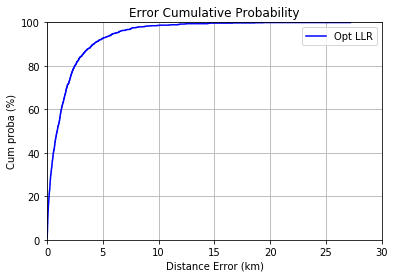

In [200]:
clf_rf_lat = RandomForestRegressor(n_estimators = best_n_estimators, max_depth=best_max_depth,
                                   max_features = best_max_features, n_jobs=-1)
clf_rf_lat.fit(Xtrain_cv, y_lat_train_cv)
y_pred_lat = clf_rf_lat.predict(Xtest_cv) 

clf_rf_lng = RandomForestRegressor(n_estimators = best_n_estimators, max_depth=best_max_depth,
                                   max_features = best_max_features, n_jobs=-1)
clf_rf_lng.fit(Xtrain_cv, y_lng_train_cv)
y_pred_lng = clf_rf_lng.predict(Xtest_cv)

err_vec = Eval_geoloc(y_lat_test_cv , y_lng_test_cv, y_pred_lat, y_pred_lng)

grap_error(err_vec)

## Etude avec un Extratrees Regressor - hyper-paramètres testés : max_depth, max_features, n_estimators

In [198]:
# Gridsearch manuel (impossible d'utiliser les fonctions classiques car ici il y a 2 modèles à optimiser)
list_max_depth = [20, 25, 30, 35, 40, 45, 50, 55, 60]
list_max_features = [0.5, 0.6, 0.7, 0.8, 0.9, None]
list_n_estimators = [50, 100, 200]
  
err80 = 10000
list_result =[]
for max_depth in list_max_depth:
    for max_features in list_max_features:
        for n_estimators in list_n_estimators:
    
            clf_et_lat = ExtraTreesRegressor(n_estimators = n_estimators, max_depth=max_depth,
                                               max_features = max_features, n_jobs=-1)
            clf_et_lat.fit(Xtrain_cv, y_lat_train_cv)
            y_pred_lat = clf_et_lat.predict(Xtest_cv) 

            clf_et_lng = ExtraTreesRegressor(n_estimators = n_estimators, max_depth=max_depth,
                                               max_features = max_features,n_jobs=-1)
            clf_et_lng.fit(Xtrain_cv, y_lng_train_cv)
            y_pred_lng = clf_et_lng.predict(Xtest_cv)

            err_vec = Eval_geoloc(y_lat_test_cv , y_lng_test_cv, y_pred_lat, y_pred_lng)
            perc = np.percentile(err_vec, 80)
            list_result.append((max_depth,max_features,n_estimators, perc))
            if perc < err80: # distance erreur mini pour 80% des observations
                err80 = perc
                best_max_depth = max_depth
                best_max_features = max_features
                best_n_estimators = n_estimators    
                
print('best_max_depth', best_max_depth) 
print('best_max_features', best_max_features)
print('best_n_estimators', best_n_estimators)
print('err80', err80)

best_max_depth 45
best_max_features 0.5
best_n_estimators 100
err80 2343.2609280230417


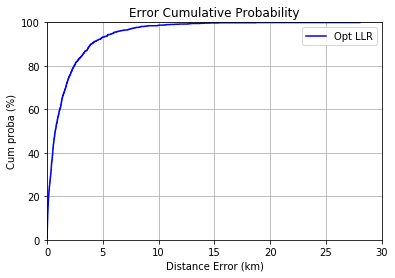

In [202]:
clf_et_lat = ExtraTreesRegressor(n_estimators = best_n_estimators, max_depth=best_max_depth,
                                    max_features = best_max_features, n_jobs=-1)
clf_et_lat.fit(Xtrain_cv, y_lat_train_cv)
y_pred_lat = clf_et_lat.predict(Xtest_cv) 

clf_et_lng = ExtraTreesRegressor(n_estimators = best_n_estimators, max_depth=best_max_depth,
                                   max_features = best_max_features,n_jobs=-1)
clf_et_lng.fit(Xtrain_cv, y_lng_train_cv)
y_pred_lng = clf_et_lng.predict(Xtest_cv)

err_vec = Eval_geoloc(y_lat_test_cv , y_lng_test_cv, y_pred_lat, y_pred_lng)

grap_error(err_vec)

On obtient un meilleur résultat avec Extratrees, on garde donc ce modèle.

## Construction fichier de prédiction

In [203]:
# On prédit sur le test set à partir de l'algorithme d'Extratrees entraîné précédemment
y_pred_lat_final = clf_et_lat.predict(X_test)
y_pred_lng_final = clf_et_lng.predict(X_test)

In [204]:
# Construction du fichier de prédiction
test_res = pd.DataFrame(np.array([y_pred_lat_final, y_pred_lng_final]).T, columns = ['lat', 'lng'])

test_res.to_csv('pred_pos_test_list.csv', index=False)
test_res.head()

,lat,lng
0,39.759956,-105.087983
1,39.782231,-105.070782
2,39.689431,-105.021074
3,39.784156,-105.073378
4,39.689972,-105.019475


# Ok jusqu'ici

## Prédicteur one device_out

Pour créer le prédicteur one device out, on repart de notre matrice de features existantes :

In [205]:
df_train.head(5)

,bs1012,bs1086,bs1092,bs1131,bs1264,bs1268,bs1292,bs1334,bs1344,bs1432,bs1476,bs1530,bs1594,bs1661,bs1741,bs1743,bs1772,bs1796,bs1826,bs1854,bs1859,bs1872,bs1878,bs1987,bs1988,bs1994,bs1996,bs2189,bs2605,bs2610,bs2617,bs2693,bs2707,bs2731,bs2737,bs2762,bs2768,bs2775,bs2776,bs2784,bs2790,bs2799,bs2800,bs2803,bs2831,bs2837,bs2841,bs2842,bs2846,bs2862,bs2943,bs2999,bs3025,bs3034,bs3051,bs3256,bs3357,bs3378,bs3386,bs3389,bs3402,bs3403,bs3410,bs3412,bs3414,bs3415,bs3500,bs3526,bs3527,bs3529,bs3535,bs3536,bs3538,bs3545,bs3547,bs3548,bs3553,bs3554,bs3555,bs3556,bs3558,bs3559,bs3562,bs3563,bs3565,bs3568,bs3569,bs3570,bs3571,bs3574,bs3575,bs3576,bs3578,bs3579,bs3581,bs3613,bs3629,bs3630,bs3828,bs3835,bs3846,bs3848,bs3907,bs3983,bs4024,bs4047,bs4056,bs4058,bs4059,bs4064,bs4065,bs4078,bs4092,bs4105,bs4129,bs4147,bs4148,bs4156,bs4157,bs4205,bs4244,bs4646,bs4790,bs4819,bs4966,bs4987,bs4993,bs7248,bs7382,bs7435,bs7456,bs7692,bs7726,bs7738,bs7789,bs7807,bs8082,bs8168,bs8245,bs8351,bs8352,bs8355,bs8356,bs8364,bs8368,bs8370,bs8371,bs8392,bs8397,bs8426,...,did472504,did472511,did472516,did472518,did472526,did472533,did472646,did472654,did472660,did472676,did472851,did472854,did472960,did473056,did473058,did473066,did473067,did473069,did473071,did473094,did473229,did473231,did473259,did473266,did473269,did473275,did473277,did473279,did473281,did473287,did473288,did473335,did473368,did473401,did473438,did473502,did473507,did473512,did473683,did473796,did473805,did473864,did473871,did473892,did473897,did473899,did473902,did473953,did474126,did474176,did474181,did474192,did476123,did476140,did476161,did476185,did476207,did476210,did476212,did476225,did476228,did476231,did476248,did476251,did476253,did476256,did476257,did476274,did476275,did476276,did476280,did476285,did476286,did476306,did476307,did476308,did476312,did476314,did476315,did476316,did476317,did476318,did476320,did476321,did476322,did476323,did476324,did476325,did476327,did476329,did476331,did476332,did476337,did476503,did476505,did476507,did476512,did476513,did476515,did476517,did476521,did476523,did476525,did476567,did476593,did476594,did476596,did476598,did476600,did476602,did476604,did476606,did476607,did476609,did476610,did476611,did476615,did476826,did476828,did476829,did476830,did476833,did476835,did476836,did476841,did476852,did476853,did476861,did476868,did476883,did476884,did476885,did476887,did476888,did476889,did476891,did476896,did476987,did477023,did477201,did1747434,did1747448,mean_rssi,mean_lat,mean_lng,mean_lat_rssi,mean_lng_rssi,mean_time_ux,pos_lat,pos_lng
messid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
573bf1d9864fce1a9af8c5c9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

On décide quand même de supprimer les features les moins importantes sans prendre en compte les variables catégorielles liées au device id.

In [93]:
# Transformation en Numpy array
X_train2 = df_train.iloc[:,:-2]
y_lat_train2 = df_train.pos_lat
y_lng_train2 = df_train.pos_lng

X_test2 = df_test

In [94]:
# On enlève les features avec importance < 0.00025
seuil_importance = 0.000025
index_to_remove4 = list(set(feature_importances_lat[feature_importances_lat.importance < seuil_importance].iloc[:,0]).intersection(set(feature_importances_lng[feature_importances_lng.importance < seuil_importance].iloc[:,0])))
index_to_remove4 = list(filter(lambda x : x.find('did'),index_to_remove4))

print("%d features ont une importance inférieure à %.6f." %(len(index_to_remove4), seuil_importance))
X_train2 = X_train2.drop(index_to_remove4, axis=1)
X_test2 = X_test2.drop(index_to_remove4, axis=1)

123 features ont une importance inférieure à 0.000025.


On crée un test de validation en retirant un device.
Pour l'exemple, on enlève le device qui correspond à l'attribut did121.

In [99]:
device_id_out = 'did121'

In [100]:
# On récupère les index qui concernent le device qu'on cherche à retirer du dataset
index_to_keep = X_train2[X_train2[device_id_out]==0].index
index_device_out = X_train2[X_train2[device_id_out]==1].index

Xtrain_cv2 = X_train2.loc[index_to_keep]
Xtest_cv2 = X_train2.loc[index_device_out]

y_lat_train_cv2 = y_lat_train2.loc[index_to_keep]
y_lat_test_cv2 = y_lat_train2.loc[index_device_out]

y_lng_train_cv2 = y_lng_train2.loc[index_to_keep]
y_lng_test_cv2 = y_lng_train2.loc[index_device_out]

On choisit d'entraîner sur le modèle ExtraTrees avec les paramètres de la partie précédente.

In [101]:
# On entraîne notre modèle Extratrees sur 80% du train set et on valide sur les 20% restants 
clf_lat = ExtraTreesRegressor(n_estimators=200, max_features=0.7, max_depth=40, n_jobs=-1)
clf_lat.fit(Xtrain_cv2, y_lat_train_cv2)
y_pred_lat = clf_lat.predict(Xtest_cv2)
clf_lng = ExtraTreesRegressor(n_estimators=200, max_features=0.7, max_depth=40, n_jobs=-1)
clf_lng.fit(Xtrain_cv2, y_lng_train_cv2)
y_pred_lng = clf_lng.predict(Xtest_cv2)

err_vec = Eval_geoloc(y_lat_test_cv2 , y_lng_test_cv2, y_pred_lat, y_pred_lng)
print("Erreur de distance cumulé à 80% : {}" .format((np.percentile(err_vec, 80))))

Erreur de distance cumulé à 80% : 1629.2303531654109


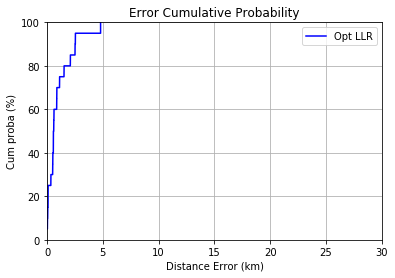

In [102]:
# On affiche le graphe des erreurs de distance cumulées
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.show()